In [65]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
from langchain_core.messages import AIMessage,HumanMessage
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = os.getenv('LANGSMITH_API_KEY')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')

In [67]:
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)
# print(arxiv.invoke("Attentions is all you need"))


wiki_api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)
# print(arxiv.invoke("Attentions is all you need"))


def add(a, b):
    """Return the sum of a and b.

    Parameters
    ----------
    a : numeric
        First addend.
    b : numeric
        Second addend.

    Returns
    -------
    numeric
        The result of a + b.
    """
    return a + b


def multiply(a, b):
    """Return the product of a and b.

    Parameters
    ----------
    a : numeric
        First factor.
    b : numeric
        Second factor.

    Returns
    -------
    numeric
        The result of a * b.
    """
    return a * b


def divide(a, b):
    """Return the division of a by b.

    Parameters
    ----------
    a : numeric
        Numerator.
    b : numeric
        Denominator; must not be zero.

    Returns
    -------
    float
        The result of a / b.

    Raises
    ------
    ZeroDivisionError
        If ``b`` is zero.
    """
    if b == 0:
        raise ZeroDivisionError("division by zero")
    return a / b

In [ ]:
tools = [arxiv,wiki,add,multiply,divide]

# LLM Initiate
chatgroq = ChatGroq(model='qwen/qwen3-32b')

chatgroq_tools = chatgroq.bind_tools(tools)

print(chatgroq_tools.invoke([HumanMessage(content="Whats machine learning")]))

content='Machine learning is a subset of artificial intelligence (AI) that focuses on developing algorithms and statistical models that enable computers to perform tasks without explicit instructions. Instead, systems learn patterns and insights from data, improving their performance over time through experience. Key types include:\n\n1. **Supervised Learning**: Uses labeled data to train models (e.g., predicting house prices based on features).\n2. **Unsupervised Learning**: Finds hidden patterns in unlabeled data (e.g., clustering customers by behavior).\n3. **Reinforcement Learning**: Learns by interacting with an environment to maximize rewards (e.g., training a robot to walk).\n\nApplications span image recognition, recommendation systems, fraud detection, and natural language processing. Core concepts include training data, validation, overfitting, and algorithms like neural networks or decision trees. For deeper exploration, I can fetch a Wikipedia summary!' additional_kwargs={'

In [ ]:
# ### Entire Chatbot With LangGraph
# from IPython.display import Image, display
# from langgraph.graph import StateGraph, START, END
# from langgraph.prebuilt import ToolNode
# from langgraph.prebuilt import tools_condition

# ### Node definition
# def tool_calling_llm(state:State):
#     return {"messages":[llm_with_tools.invoke(state["messages"])]}

# # Build graph
# builder = StateGraph(State)
# builder.add_node("tool_calling_llm", tool_calling_llm)
# builder.add_node("tools", ToolNode(tools))

# builder.add_edge(START, "tool_calling_llm")
# builder.add_conditional_edges(
#     "tool_calling_llm",
#     # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
#     tools_condition,
# )
# builder.add_edge("tools","tool_calling_llm")


# graph = builder.compile()

# # View
# display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
import os
from typing import List, Annotated
from pydantic import BaseModel

from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

In [ ]:
llm=init_chat_model("groq:qwen/qwen3-32b")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000024AAD6FA900>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024AAD6FB620>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

docs


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [ ]:
## Recursive character text ssplitter an vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()

In [ ]:
vectorstore.get(limit=5)

{'ids': ['0684c20b-db44-4083-a5ca-9e7b308310cd',
  'c9b9ac95-2c1e-478e-9b4e-3cd88f17746b',
  '515a7728-fcc1-4538-9a0d-d0292ed5bef0',
  'c2181e5d-f082-4309-80fe-0834ed29628a',
  '80bcd21e-05dd-4dd9-b761-2756f3086b27'],
 'embeddings': None,
 'documents': ["LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)",
  'Maximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation

In [ ]:
retriever.invoke("What are agents")

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

Langgraph RAG

In [ ]:
# State
class RAGState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [54]:
# Langgraph Nodes
def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    # print("Inside Retriever", docs)
    return RAGState(question=state.question,retrieved_docs=docs)

def generate_response(state:RAGState) -> RAGState:
    content = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    # print("Responder",content)
    prompt = f"Answer the question based on the retrieved documents: \n\n {content}\n\n for the Question: {state.question}"
    llm_response = llm.invoke(prompt)
    answer_text = llm_response.content if hasattr(llm_response, 'content') else str(llm_response)
    return RAGState(question=state.question,etrieved_docs=state.retrieved_docs,answer=answer_text)

In [55]:
# Graph
builder = StateGraph(RAGState)
builder.add_node("retriever",retrieve_docs)
builder.add_node("responder",generate_response)

builder.set_entry_point("retriever")
builder.add_edge("retriever","responder")
builder.add_edge("responder",END)

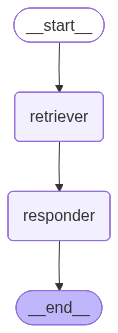

In [56]:
graph = builder.compile()
graph

In [57]:
if __name__ == "__main__":
    question = "Whats the concept of agents loop in Autonomous Agents?"
    initial_state = RAGState(question=question)
    final_state = graph.invoke(initial_state)
    print("Answer: ",final_state['answer'])

Answer:  <think>
Okay, let's tackle this question about the concept of the agents loop in autonomous agents. First, I need to recall what the retrieved documents mentioned. The user provided some information about generative agents combining LLM with memory, planning, and reflection. They also mentioned a study by Boiko et al. (2023) on agents for scientific discovery, handling experiments, using tools like browsing the internet, executing code, etc. There's an example of developing an anticancer drug with reasoning steps. The references include Chain of Thought and Tree of Thoughts prompting. Also, self-reflection is highlighted as vital for iterative improvement.

Now, the question is about the agents loop. From what I remember, autonomous agents typically operate in a loop that involves perceiving the environment, making decisions, taking actions, and learning from outcomes. But the user's context adds specific elements like memory, planning, and reflection. So I need to integrate t